In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator

## Reduce catalog to the optical photometry F475W and F814W
## Save optical catalog to a csv file

### Takes some time to complete

In [2]:
# phast_catalog = fits.open("/Users/mmckay/phd_projects/analysis_routine/DATA/4band-merged.fits")

# phast_catalog.info()
# phast_catalog[1].header['*']

# phast_table = phast_catalog[1].data
# phast_table.shape

# phast_table = Table()
# phast_table['ra'] = phast_catalog[1].data['ra']
# phast_table['dec'] = phast_catalog[1].data['dec']

# # F475W
# phast_table['f475w_vega'] = phast_catalog[1].data['f475w_vega']
# phast_table['f475w_snr'] = phast_catalog[1].data['f475w_snr']
# phast_table['f475w_crowd'] = phast_catalog[1].data['f475w_crowd']
# phast_table['f475w_sharp'] = phast_catalog[1].data['f475w_sharp']
# phast_table['f475w_flag'] = phast_catalog[1].data['f475w_flag']


# # F814W
# phast_table['f814w_vega'] = phast_catalog[1].data['f814w_vega']
# phast_table['f814w_snr'] = phast_catalog[1].data['f814w_snr']
# phast_table['f814w_crowd'] = phast_catalog[1].data['f814w_crowd']
# phast_table['f814w_sharp'] = phast_catalog[1].data['f814w_sharp']
# phast_table['f814w_flag'] = phast_catalog[1].data['f814w_flag']

# df = phast_table.to_pandas()
# df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv', index=True)

# Reduce the optical catalog using the Gregersen et al 2015 criteria for RGB stars and plot color magnitude diagram

In [51]:
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv', nrows=5000000)

# Gregersen et al 2015 criteria for RGB stars
phast_df = df.loc[(df['f475w_flag'] == 0.0) & (df['f814w_flag'] == 0.0)
                     & (df['f475w_snr'] >= 4.0) & (df['f814w_snr'] >= 4.0)
                     & (df['f475w_crowd']+df['f814w_crowd'] <= 1.0)
                     & ((df['f475w_sharp']+df['f814w_sharp'])**2 <= 0.075)
                    #  & (df['f814w_vega'] <= 23.0) # Apply after foreground reddening correction
                     ]
phast_df.describe()

# Plot CMD
joint = sns.jointplot(x=(phast_df['f475w_vega']-phast_df['f814w_vega']), y=phast_df['f814w_vega'], kind='kde', color='grey')
# plt.xlim(-1, 8)
plt.ylim(25, 20)
joint.ax_marg_x.set_xlim(-1, 8)


sns.pairplot(phast_df, vars=['f475w_vega', 'f814w_vega'], kind='kde')


# Foreground extinction correction 

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_4100/2022540412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_4100/2022540412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_4100/2022540412.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

(-1.0, 8.0)

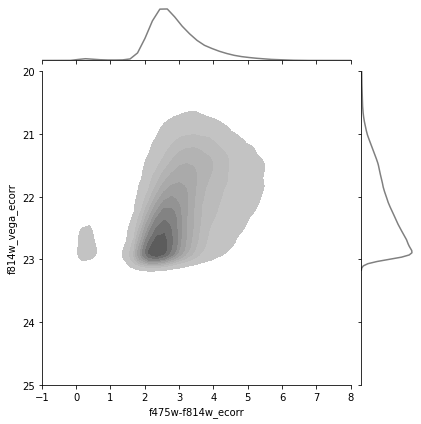

In [39]:
# # Foreground extinction correction A_lam/A_V = 0.60593
# phast_df['f814w_vega_ecorr'] = phast_df['f814w_vega']  - (2.5 * np.log(0.60593))
# phast_df['f475w_vega_ecorr'] = phast_df['f475w_vega'] - (2.5 * np.log(1.19119))

# A_lam/A_V: F814W=0.59696, F475W=1.21182 from CMD 3.7 output A_V = 0.17
phast_df['f814w_vega_ecorr'] = phast_df['f814w_vega'] + 0.596*0.17
phast_df['f475w_vega_ecorr'] = phast_df['f475w_vega'] + 1.212*0.17
phast_df['f475w-f814w_ecorr'] = phast_df['f475w_vega_ecorr']-phast_df['f814w_vega_ecorr']
phast_df = phast_df.loc[(phast_df['f814w_vega_ecorr'] <= 23.0)] # Apply after foreground reddening correction
# phast_df[['f814w_vega_ecorr', 'f475w_vega_ecorr','f475w-f814w_ecorr' ]].describe()
phast_df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/test_reduced_phast_catalog.csv', index=True)

joint = sns.jointplot(x=phast_df['f475w-f814w_ecorr'], y=phast_df['f814w_vega_ecorr'], kind='kde', shade=True, color='grey')
# plt.xlim(-1, 8)
plt.ylim(25, 20)
joint.ax_marg_x.set_xlim(-1, 8)

In [5]:
# sns.pairplot(phast_df, vars=['f475w_vega', 'f814w_vega', 'f475w_vega_ecorr', 'f814w_vega_ecorr', 'f475w-f814w_ecorr' ])

In [6]:
# Function to convert vega magnitude to bolometric magnitude
# 1. Calculate the absolute bolometric magnitude
# - M_abs = M_bol - BC_filter

In [7]:
# def vega_to_bolometric_vega(vega_mag, solar_bolmag, solar_lum):
#     vega_bol_lum = -1 * np.sqrt(vega_mag/2.5) * solar_lum
#     return solar_bolmag - vega_bol_lum

# Process the CMD output tables using cmd_table_processing.py

In [9]:
# M/H :-2.18 - 0.03 #Isopchrone table 1
# !python /Users/mmckay/phd_projects/analysis_routine/code/cmd_table_processing.py '/Users/mmckay/phd_projects/analysis_routine/DATA/CMD3_7_outputs/output901257569509.dat'

# M/H: 0.03 - 0.06 #Isopchrone table 2
# !python /Users/mmckay/phd_projects/analysis_routine/code/cmd_table_processing.py '/Users/mmckay/phd_projects/analysis_routine/DATA/CMD3_7_outputs/output458449038052.dat'


Processing file: 49609line [01:10, 702.32line/s]
Merged Dataframe Complete
Processing file: 51744line [01:20, 640.13line/s]
Merged Dataframe Complete


# Evaluate CMD table from cmd_table_processing.py script


In [22]:
# Concatenate into single table
iso_df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output901257569509/merged_output901257569509.csv')
iso_df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output458449038052/merged_output458449038052.csv')
cmd_df = pd.concat([iso_df1, iso_df2], ignore_index=True)
cmd_df.describe()


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Cexcess,Z,mbolmag,F435Wmag,F475Wmag,F555Wmag,F606Wmag,F625Wmag,F775Wmag,F814Wmag
count,101056.000000,101056.000000,1.010560e+05,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,...,101056.0,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000
mean,0.030751,0.235967,9.602060e+00,1.276640,2.482673,1.200121,1.930644,3.587306,1.821063,4.778707,...,-1.0,0.030935,-0.056609,3.799451,3.231933,2.540124,1.885459,1.574086,0.239444,0.011866
std,0.016870,0.417161,3.552731e-15,0.279960,0.179835,0.288313,1.682522,0.114797,1.726959,2.731832,...,0.0,0.017018,4.206291,3.706848,3.663562,3.629930,3.593540,3.603359,3.708358,3.762092
min,0.000100,-2.191740,9.602060e+00,0.090000,1.081690,0.090000,-9.999000,3.344000,-1.092000,0.000000,...,-1.0,0.000034,-4.576000,-1.743000,-2.300000,-3.018000,-3.493000,-3.801000,-4.482000,-4.584000
25%,0.016500,0.052940,9.602060e+00,1.271277,2.516076,1.117000,1.177000,3.496600,0.279000,3.000000,...,-1.0,0.016440,-3.340000,1.675000,1.051000,0.375000,-0.138000,-0.439000,-2.036000,-2.422000
50%,0.030600,0.346000,9.602060e+00,1.394392,2.529421,1.318000,2.211000,3.594500,1.786000,4.000000,...,-1.0,0.030430,-0.757000,2.809000,2.314000,1.681000,0.940000,0.596000,-0.915000,-1.092000
75%,0.045300,0.543860,9.602060e+00,1.424918,2.532322,1.401000,3.244000,3.666000,3.006000,8.000000,...,-1.0,0.045810,1.827000,4.258000,3.848000,3.221000,2.831000,2.633000,1.190250,1.126250
max,0.059900,0.694320,9.602060e+00,1.443930,2.534058,1.425000,3.738000,4.000000,5.469000,9.000000,...,-1.0,0.060420,29.767000,30.028000,30.064000,30.072000,30.066000,30.068000,30.074000,30.062000


# Convert Isochrone tables absolute magnitudes to photometric brightness (apprent magnituides)
### m-M (distance modules) = 24.45mag +- 0.05
### m-M = -5 + 5(log(d))
### m = M - 5 + 5 * np.log10(d)
### d = np.exp((m - M + 5) / 5)

In [23]:
dist_mod = 24.45
d = 10 ** ((dist_mod + 5) / 5)
cmd_df['F475W_appmag'] = cmd_df['F475Wmag'] - 5 + 5 * np.log10(d)
cmd_df['F814W_appmag'] = cmd_df['F814Wmag'] - 5 + 5 * np.log10(d)
cmd_df['F475Wmag-F814Wmag'] = cmd_df['F475Wmag'] - cmd_df['F814Wmag']
cmd_df['F475W_appmag-F814W_appmag'] = cmd_df['F475W_appmag'] - cmd_df['F814W_appmag']

# Save isochrone master final CSV ready for analysis!
cmd_df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_isochrone_table.csv', index=False)


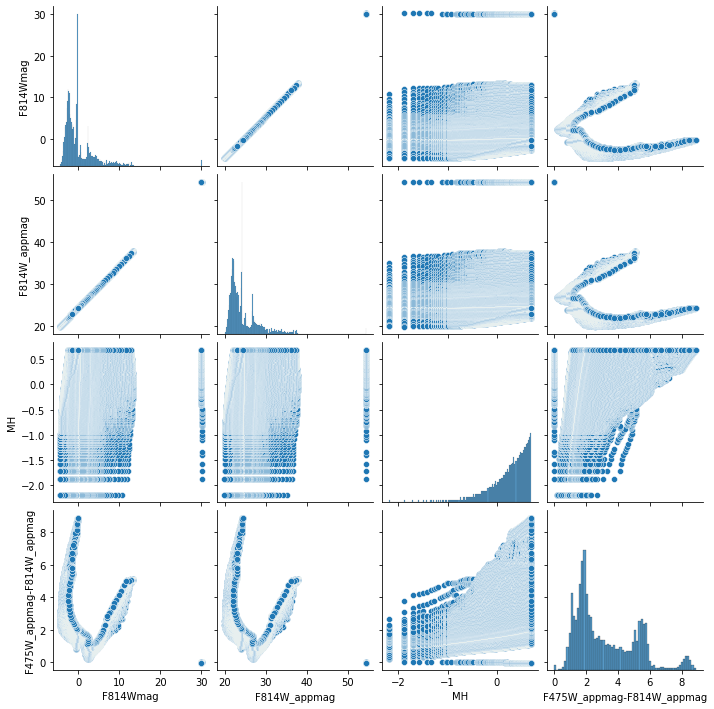

In [4]:

# Examine new columns with original
cmd_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_isochrone_table.csv')
g = sns.pairplot(cmd_df[['F814Wmag', 'F814W_appmag', 'MH', 'F475W_appmag-F814W_appmag']])
# g.axes[:].invert_yaxis()
plt.show()



In [20]:
# Split the newly merged by metallicity value and replace saved dataframe
##! Issue: Some dataframes are being merged with next isochrone randomly 
# Split cmd_df by metallicity value
# cmd_df_split = pd.DataFrame()
# for zini_value in cmd_df['Zini'].unique():
#     cmd_df_split = pd.DataFrame(cmd_df[cmd_df['Zini'] == zini_value])
#     cmd_df_split.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_tables/output_{}.csv'.format(zini_value), index=False)



/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

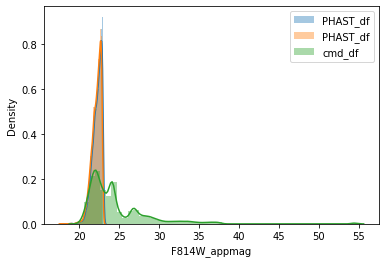

In [5]:
import seaborn as sns

sns.distplot(phast_df['f814w_vega_ecorr'], label='PHAST_df')
sns.distplot(phast_df['f814w_vega'], label='PHAST_df')
sns.distplot(cmd_df['F814W_appmag'], label='cmd_df')
plt.legend()
plt.show()


/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


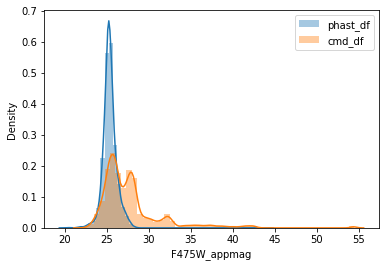

In [13]:
import seaborn as sns

sns.distplot(phast_df['f475w_vega_ecorr'], label='phast_df')
sns.distplot(cmd_df['F475W_appmag'], label='cmd_df')
plt.legend()
plt.show()


# Linear Interpolation between PHAST and Isochrone Tables
GitHub Copilot: The `LinearNDInterpolator` function from the `scipy.interpolate` module is used to create a linear interpolation object. In this code, it is used to interpolate between the 2D array of F475W and F814W magnitudes from `cmd_df` and the 2D array of f475w_vega and f814w_vega magnitudes from `phast_df`. The `interp` object is then used to find the closest index in `cmd_df` for each row in `phast_df`. The closest index is added as a new column in `phast_df`, and then `phast_df` is merged with `cmd_df` on the closest index. Finally, the merged dataframe is printed, showing the F475W and F814W magnitudes from `cmd_df` and the f475w_vega and f814w_vega magnitudes from `phast_df`.

In [14]:
from scipy.interpolate import LinearNDInterpolator

# create a 2D array of F475W and F814W magnitudes from cmd_df
cmd_arr = cmd_df[['F475W_appmag', 'F814W_appmag']].values

# create a LinearNDInterpolator object
interp = LinearNDInterpolator(cmd_arr, cmd_df.index)

# create a 2D array of f475w_vega and f814w_vega magnitudes from phast_df
filtered_arr = phast_df[['f475w_vega_ecorr', 'f814w_vega_ecorr']].values

# find the closest index in cmd_df for each row in phast_df
closest_index = interp(filtered_arr)

# add the closest index as a new column in phast_df
phast_df['closest_index'] = closest_index.astype(int)

# merge phast_df with cmd_df on closest_index
merged_df = pd.merge(phast_df, cmd_df, left_on='closest_index', right_index=True)

# print the merged dataframe
merged_df[['f475w_vega', 'f814w_vega', 'F475W_appmag', 'F814W_appmag', 'f475w-f814w_ecorr']].describe()


/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_12324/3750034285.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phast_df['closest_index'] = closest_index.astype(int)


,f475w_vega,f814w_vega,F475W_appmag,F814W_appmag,f475w-f814w_ecorr
count,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000
mean,25.184501,22.158304,27.940017,24.542805,3.130917
std,0.744535,0.545685,3.815811,3.899496,0.809106
min,22.287250,19.807750,22.166000,19.952000,1.153720
25%,24.738312,21.801750,25.624000,22.157250,2.555344
50%,25.103000,22.260875,26.884000,23.311000,2.956722
75%,25.545062,22.614438,28.369000,25.200000,3.539595
max,28.248500,22.898500,54.459000,54.467000,6.416720


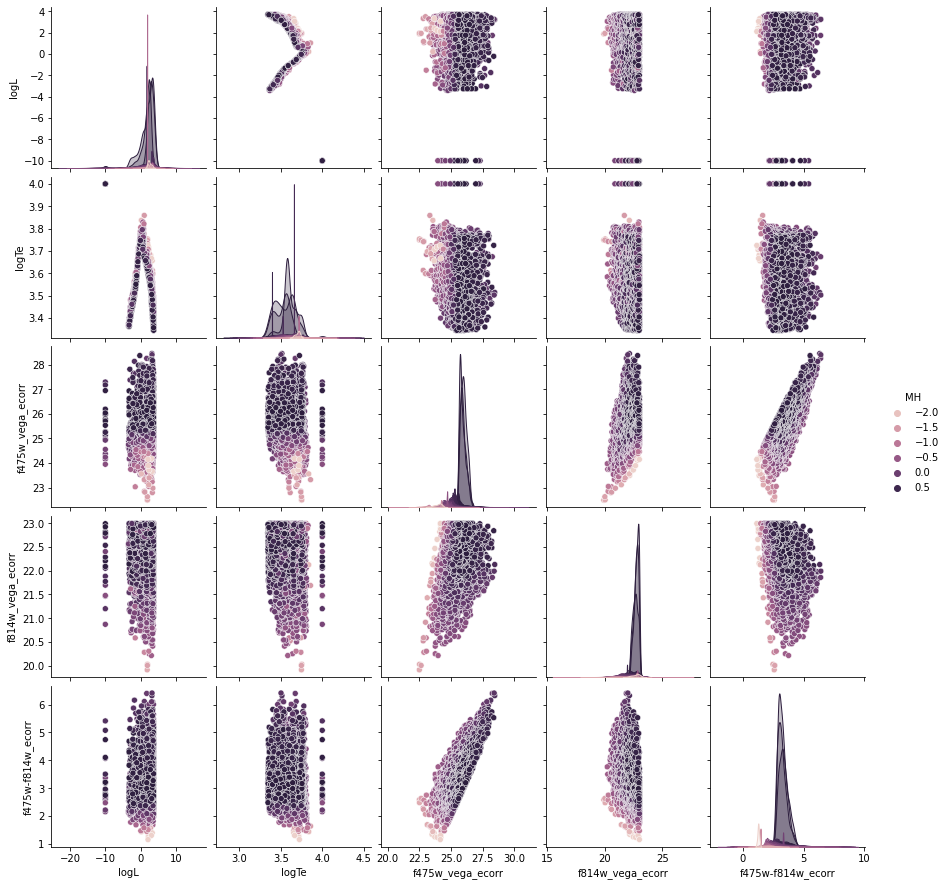

In [15]:
import seaborn as sns

sns.pairplot(merged_df[['logL', 'logTe', 'f475w_vega_ecorr', 'f814w_vega_ecorr', 'MH', 'f475w-f814w_ecorr']], hue='MH')


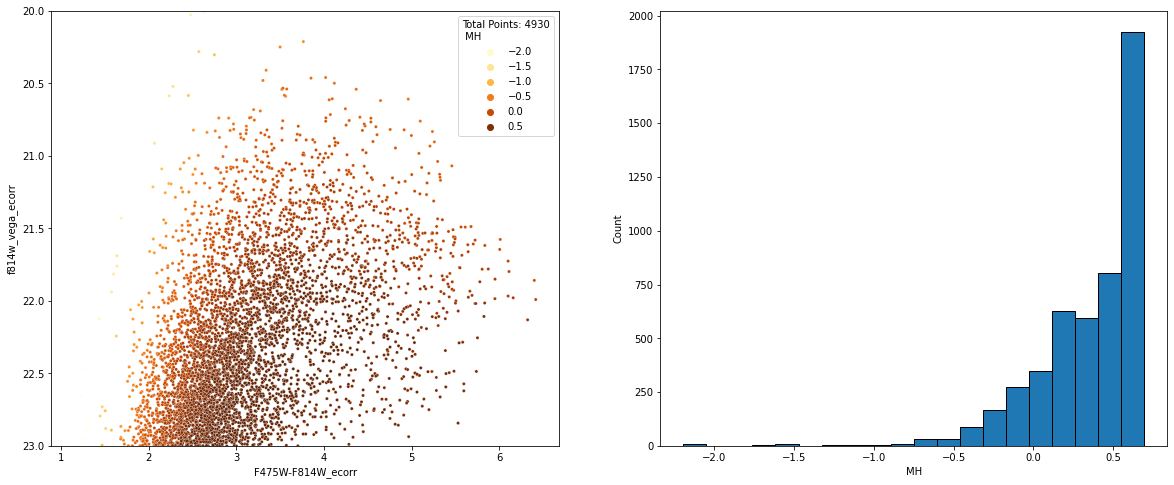

In [16]:
fig, ((ax1,ax2)) = plt.subplots(1,2, figsize=(20, 8))
sns.scatterplot(x=merged_df['f475w-f814w_ecorr'] , y=merged_df['f814w_vega_ecorr'], 
                s=10, hue=merged_df['MH'], palette='YlOrBr', alpha=1, ax=ax1)
sns.histplot(x=merged_df['MH'], alpha=1, bins=20, ax=ax2)
ax1.set_ylim(23, 20)
ax1.set_xlabel('F475W-F814W_ecorr')
ax1.legend(title=f"Total Points: {len(merged_df)}\n MH")
plt.show()


In [17]:
# sns.jointplot(x=merged_df['f475w_vega']-merged_df['f814w_vega'], y=merged_df['f814w_vega'], kind='kde', hue=merged_df['MH'], fill=False, legend=False)
# # sns.scatterplot(merged_df['f475w_vega']-merged_df['f814w_vega'], y=merged_df['f814w_vega'], s=1, hue=merged_df['MH'], legend=False)
# plt.gca().invert_yaxis()
# plt.xlabel('F475W-F814W')
# plt.show()


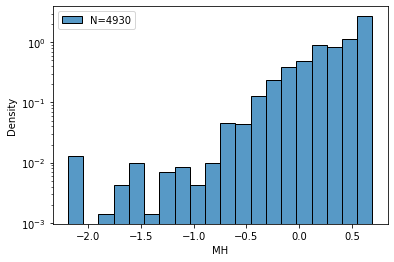

In [18]:

import matplotlib.pyplot as plt

sns.histplot(data=merged_df, x='MH', label=f'N={len(merged_df)}', bins=20, kde=False, stat='density')
plt.yscale('log')
plt.legend()


# Examine individual metallicity range isochrone tables

1.0212168679508198 1.3260362444707448


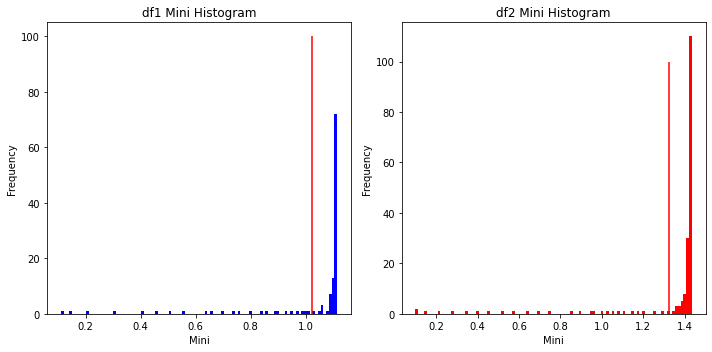

In [269]:
# plot isochrone in CMD phase space
df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_tables/output_0.0001.csv')
df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_tables/output_0.0299.csv')
print(df1['Mini'].mean(), df2['Mini'].mean())

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for df1 Mini column
axs[0].hist(df1['Mini'], bins=100, color='blue')
axs[0].set_title('df1 Mini Histogram')
axs[0].set_xlabel('Mini')
axs[0].set_ylabel('Frequency')
axs[0].vlines(df1['Mini'].mean(), ymin=0, ymax=100, color='red', label='Mean')

# Plot histogram for df2 Mini column
axs[1].hist(df2['Mini'], bins=100, color='red')
axs[1].set_title('df2 Mini Histogram')
axs[1].set_xlabel('Mini')
axs[1].set_ylabel('Frequency')
axs[1].vlines(df2['Mini'].mean(), ymin=0, ymax=100, color='red', label='Mean')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [270]:
# Making interactive plots with plotly
import plotly.express as px
import plotly.graph_objects as go

# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("df1", "df2"))

# Add scatter plot for df1
fig.add_trace(go.Scatter(x=df1['F475W_appmag-F814W_appmag'], y=df1['F814W_appmag'], mode='markers', name='df1', 
                         marker=dict(color=df1['Mini'], 
                                     colorscale='magma_r', 
                                     colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="right", yanchor="middle", titleside="top", x=0.4, y=1.1))), 
                                    row=1, col=1)

# Add scatter plot for df2
fig.add_trace(go.Scatter(x=df2['F475W_appmag-F814W_appmag'], y=df2['F814W_appmag'], mode='markers', name='df2', 
                         marker=dict(color=df2['Mini'], 
                                     colorscale='magma_r', 
                                     colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1))), 
                                     row=1, col=2)

# Update layout
fig.update_layout(height=700, width=1000, title_text="Subplots", title='Isochrone CMDs')

# Inverse y-axes
fig.update_yaxes(autorange="reversed")

# Show the plot
fig.show()


## Testing reduction of the ioschrone to isolate RGB stars


Text(0.5, 1.0, 'Zini: 0.0299')

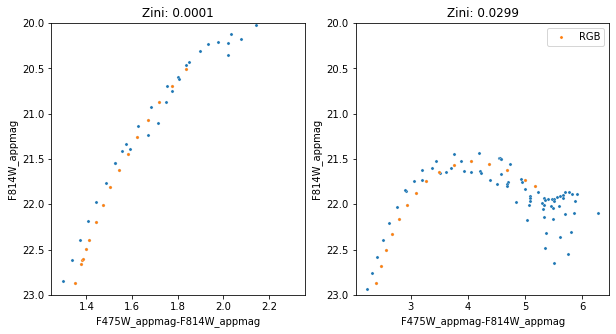

In [271]:
# Testing reduction of the ioschrone to isolate RGB stars
df1 = df1.loc[(df1['F814W_appmag'] <= 23.0)]
df2 = df2.loc[(df2['F814W_appmag'] <= 23.0)]

# Get the first value in the MH column
# first_mh = df1['MH'].iloc[0]

# Isolate RGB stars using the mean of the initial mass distribution
rgb_df1 = df1.loc[(df1['Mini'] < df1['Mini'].mean())]
rgb_df2 = df2.loc[(df2['Mini'] < df2['Mini'].mean())]

df1.describe()

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df1, x='F475W_appmag-F814W_appmag', y='F814W_appmag', s=10, legend=False, ax=ax1)
sns.scatterplot(data=rgb_df1, x='F475W_appmag-F814W_appmag', y='F814W_appmag', s=10, legend=False, ax=ax1, label='RGB')
ax1.set_ylim(23, 20)
ax1.set_title(f"Zini: {df1['Zini'].iloc[0]}")

sns.scatterplot(data=df2, x='F475W_appmag-F814W_appmag', y='F814W_appmag', s=10, legend=False, ax=ax2)
sns.scatterplot(data=rgb_df2, x='F475W_appmag-F814W_appmag', y='F814W_appmag', s=10, legend=True, ax=ax2, label='RGB')
ax2.set_ylim(23, 20)
ax2.set_title(f"Zini: {df2['Zini'].iloc[0]}")


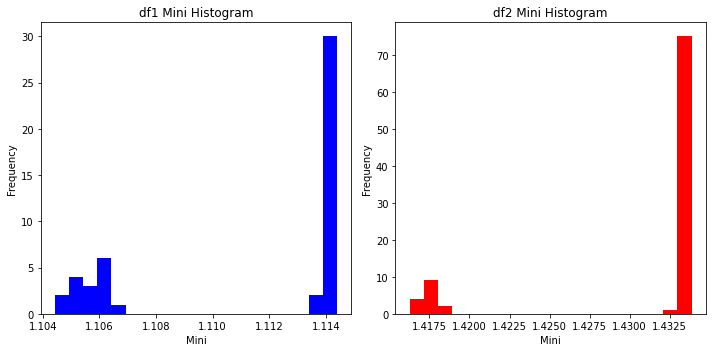

In [272]:

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for df1 Mini column
axs[0].hist(df1['Mini'], bins=20, color='blue')
axs[0].set_title('df1 Mini Histogram')
axs[0].set_xlabel('Mini')
axs[0].set_ylabel('Frequency')

# Plot histogram for df2 Mini column
axs[1].hist(df2['Mini'], bins=20, color='red')
axs[1].set_title('df2 Mini Histogram')
axs[1].set_xlabel('Mini')
axs[1].set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [280]:
# Making interactive plots with plotly
import plotly.express as px
import plotly.graph_objects as go

# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("df1", "df2"))

# Add scatter plot for df1
fig.add_trace(go.Scatter(x=df1['F475W_appmag-F814W_appmag'], y=df1['F814W_appmag'], mode='markers', name='df1', 
                         marker=dict(color=df1['Mini'], 
                                     colorscale='magma_r', 
                                     colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="right", yanchor="middle", titleside="top", x=0.4, y=1.1))), 
                                    row=1, col=1)

# Add scatter plot for df2
fig.add_trace(go.Scatter(x=df2['F475W_appmag-F814W_appmag'], y=df2['F814W_appmag'], mode='markers', name='df2', 
                         marker=dict(color=df2['Mini'], 
                                     colorscale='magma_r', 
                                     colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1))), 
                                     row=1, col=2)

# Update layout
fig.update_layout(height=700, width=1000, title_text="Subplots", title='Isochrone CMDs')

# Inverse y-axes
fig.update_yaxes(autorange="reversed")

# Show the plot
fig.show()




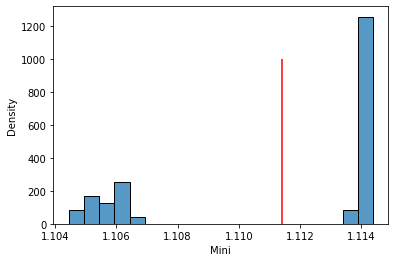

In [274]:
sns.histplot(data=df1, x='Mini', label=f'N={len(df1)}', bins=20, kde=False, stat='density')
plt.vlines(df1['Mini'].mean(), ymin=0, ymax=1000, color='red', label='Mean')

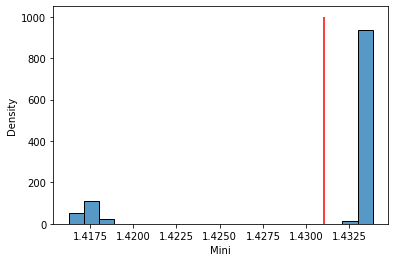

In [275]:
sns.histplot(data=df2, x='Mini', label=f'N={len(df1)}', bins=20, kde=False, stat='density')
plt.vlines(df2['Mini'].mean(), ymin=0, ymax=1000, color='red', label='Mean')

(10.0, -5.0)

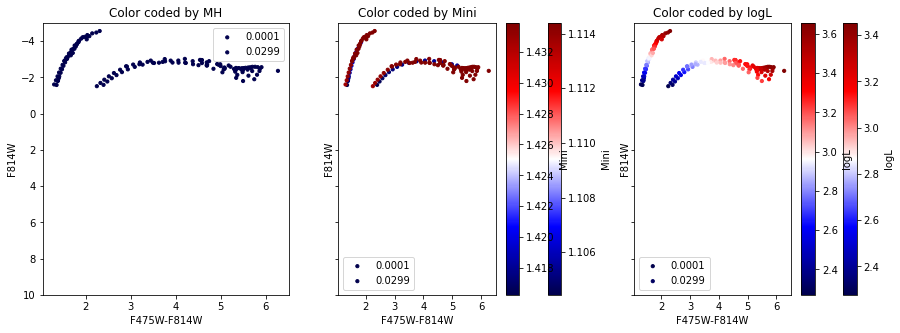

In [276]:
# create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

# plot the data for subplot 1: color coded by MH for df1
im1 = axs[0].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['MH'], cmap='seismic', s=10, label=df1['Zini'].iloc[0])
# plot the data for subplot 1: color coded by MH for df2
im2 = axs[0].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['MH'], cmap='seismic', s=10, label=df2['Zini'].iloc[0])
axs[0].set_xlabel('F475W-F814W')
axs[0].set_ylabel('F814W')
axs[0].set_title('Color coded by MH')
axs[0].legend()

# add vertical colorbar for subplot 1
# cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', label='MH')
# cbar2 = fig.colorbar(im2, ax=axs[0], orientation='vertical', label='MH')

# plot the data for subplot 2: color coded by Mini for df1
im3 = axs[1].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['Mini'], cmap='seismic', s=10, label=df1['Zini'].iloc[0])
# plot the data for subplot 2: color coded by Mini for df2
im4 = axs[1].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['Mini'], cmap='seismic', s=10, label=df2['Zini'].iloc[0])
axs[1].set_xlabel('F475W-F814W')
axs[1].set_ylabel('F814W')
axs[1].set_title('Color coded by Mini')
axs[1].legend()

# add vertical colorbar for subplot 2
cbar3 = fig.colorbar(im3, ax=axs[1], orientation='vertical', label='Mini')
cbar4 = fig.colorbar(im4, ax=axs[1], orientation='vertical', label='Mini')

# plot the data for subplot 3: color coded by logL for df1
im5 = axs[2].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['logL'], cmap='seismic', s=10, label=df1['Zini'].iloc[0])
# plot the data for subplot 3: color coded by logL for df2
im6 = axs[2].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['logL'], cmap='seismic', s=10, label=df2['Zini'].iloc[0])
axs[2].set_xlabel('F475W-F814W')
axs[2].set_ylabel('F814W')
axs[2].set_title('Color coded by logL')
axs[2].legend()

# add vertical colorbar for subplot 3
cbar5 = fig.colorbar(im5, ax=axs[2], orientation='vertical', label='logL')
cbar6 = fig.colorbar(im6, ax=axs[2], orientation='vertical', label='logL')

# plt.tight_layout()
fig.gca().invert_yaxis()
plt.ylim(10,-5)
# axs[i].invert_yaxis()


# Iterate through isochrone table and isolate RGB using the mean of the initial mass distribution and F814W apparent magnitude cuts

In [10]:
import glob
import pandas as pd
import seaborn as sns

isochrone_path_list=glob.glob('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/complete_tables/*.csv')
dfs = []
rgb_dfs = []

for isochrone_path in isochrone_path_list:
    df = pd.read_csv(isochrone_path)
    # Testing reduction of the ioschrone to isolate RGB stars
    df = df.loc[(df['F814W_appmag'] <= 23.0)]
    dfs.append(df)
    
    # Isolate RGB stars using the mean of the initial mass distribution
    rgb_df = df.loc[(df['Mini'] < df['Mini'].mean())]
    # Further reduction
    
    rgb_dfs.append(rgb_df)

    # save RGB files
    rgb_df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/RGB_isochrone_tables/RGB_Zini_{}.csv'.format(df['Zini'].iloc[0]), index=False)
    

    

RGB_merged_df = pd.concat(rgb_dfs)
RGB_merged_df = RGB_merged_df.loc[(RGB_merged_df['F475W_appmag-F814W_appmag'] <= 3.4)]
RGB_merged_df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/RGB_isochrone_table.csv', index=False)




In [ ]:
sns.jointplot(data=RGB_merged_df, x='F475W_appmag-F814W_appmag', y='F814W_appmag', legend=False)

# USING LINEARNDINTERPOLATOR FOR RGB ISOCHRONES AND THE REDUCED PHAST CATALOG

In [44]:
from scipy.interpolate import LinearNDInterpolator
RGB_merged_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/RGB_isochrone_table.csv')
phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/test_reduced_phast_catalog.csv')
# create a 2D array of F475W and F814W magnitudes from RGB_merged_df
cmd_arr = RGB_merged_df[['F814W_appmag', 'F475W_appmag-F814W_appmag']]

# create a LinearNDInterpolator object
interp = LinearNDInterpolator(cmd_arr, RGB_merged_df['MH'])

# create a 2D array of f475w_vega and f814w_vega magnitudes from phast_df
filtered_arr = phast_df[['f814w_vega_ecorr', 'f475w-f814w_ecorr']]

# find the closest index in RGB_merged_df for each row in phast_df
closest_index = interp(filtered_arr)

# add the closest index as a new column in phast_df
phast_df['closest_index'] = closest_index

# merge phast_df with RGB_merged_df on closest_index
# RGB_metallicity_df = pd.merge(phast_df, RGB_merged_df, left_on='closest_index', right_index=True)
RGB_metallicity_df = pd.merge(phast_df, RGB_merged_df[['MH']], left_on='closest_index', right_index=True)
# print the merged dataframe
# RGB_metallicity_df[['f475w_vega', 'f814w_vega', 'F475W_appmag', 'F814W_appmag', 'f475w-f814w_ecorr']].describe()

RGB_metallicity_df.head()
# RGB_metallicity_df[['f475w_vega_ecorr', 'F475W_appmag', 'f814w_vega_ecorr', 'F814W_appmag', 'closest_index', 'Zini']].head(25)

/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1205: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


,Unnamed: 0.1,Unnamed: 0,ra,dec,f475w_vega,f475w_snr,f475w_crowd,f475w_sharp,f475w_flag,f814w_vega,f814w_snr,f814w_crowd,f814w_sharp,f814w_flag,f814w_vega_ecorr,f475w_vega_ecorr,f475w-f814w_ecorr,closest_index,MH


In [53]:
from scipy.interpolate import LinearNDInterpolator

# Load the data
RGB_merged_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/RGB_isochrone_table.csv')
phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/test_reduced_phast_catalog.csv')

# Create a 2D array of F814W and F475W-F814W magnitudes from RGB_merged_df
cmd_arr = RGB_merged_df[['F814W_appmag', 'F475W_appmag-F814W_appmag']].values

# Create a LinearNDInterpolator object with 'MH' as the values
interp = LinearNDInterpolator(cmd_arr, RGB_merged_df['MH'], fill_value=-99.0)

# Create a 2D array of f814w_vega and f475w-f814w magnitudes from phast_df
filtered_arr = phast_df[['f814w_vega_ecorr', 'f475w-f814w_ecorr']].values

# Interpolate the 'MH' values for each row in phast_df
interpolated_MH = interp(filtered_arr)

# Add the interpolated 'MH' values as a new column in phast_df
phast_df['interpolated_MH'] = interpolated_MH

# Merge phast_df with RGB_merged_df on the interpolated 'MH' values
RGB_metallicity_df = pd.merge(phast_df, RGB_merged_df, left_on='interpolated_MH', right_on='MH')

# Print the merged DataFrame
RGB_metallicity_df[['f475w-f814w_ecorr', 'F475W_appmag-F814W_appmag', 'f814w_vega_ecorr', 'F814W_appmag', 'interpolated_MH', 'MH']].head(-25)

,f475w-f814w_ecorr,F475W_appmag-F814W_appmag,f814w_vega_ecorr,F814W_appmag,interpolated_MH,MH
0,2.91722,2.693,22.728319,22.968,0.69432,0.69432
1,2.91722,2.815,22.728319,22.800,0.69432,0.69432
2,2.91722,2.947,22.728319,22.643,0.69432,0.69432
3,2.91722,3.104,22.728319,22.504,0.69432,0.69432
4,2.91722,3.272,22.728319,22.377,0.69432,0.69432
...,...,...,...,...,...,...
2875,3.05122,2.693,22.589820,22.968,0.69432,0.69432
2876,3.05122,2.815,22.589820,22.800,0.69432,0.69432
2877,3.05122,2.947,22.589820,22.643,0.69432,0.69432
2878,3.05122,3.104,22.589820,22.504,0.69432,0.69432


In [59]:
phast_df = phast_df[phast_df != -99].dropna()
phast_df.head()

,Unnamed: 0.1,Unnamed: 0,ra,dec,f475w_vega,f475w_snr,f475w_crowd,f475w_sharp,f475w_flag,f814w_vega,f814w_snr,f814w_crowd,f814w_sharp,f814w_flag,f814w_vega_ecorr,f475w_vega_ecorr,f475w-f814w_ecorr,interpolated_MH
0,1,1,10.405932,40.895679,24.067749,84.550,0.01550,-0.00775,0,21.00975,252.00000,0.02250,0.00650,0,21.11107,24.273789,3.162719,-0.059642
5,8,8,10.406680,40.896795,24.053250,38.850,0.06175,-0.09175,0,21.51650,133.62500,0.03100,-0.04300,0,21.61782,24.259290,2.641470,-0.091255
6,14,14,10.405526,40.893189,24.997002,43.350,0.21450,-0.00175,0,21.77375,141.07501,0.12900,0.00175,0,21.87507,25.203042,3.327972,0.423737
8,17,17,10.404614,40.891798,24.817750,46.050,0.20575,-0.01200,0,21.84375,156.00000,0.10275,-0.00300,0,21.94507,25.023790,3.078720,0.368474
10,19,19,10.407793,40.899925,25.211250,30.375,0.09500,0.00300,0,21.93775,146.50000,0.06200,-0.01000,0,22.03907,25.417290,3.378220,0.531248


(-1.0, 8.0)

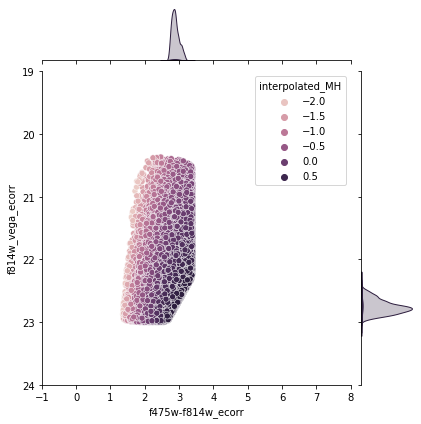

In [60]:
# joint = sns.jointplot(x=RGB_metallicity_df['f475w-f814w_ecorr'], y=RGB_metallicity_df['f814w_vega_ecorr'], kind='scatter', color='grey', hue=RGB_metallicity_df['MH'])
# plt.ylim(24, 19)
# joint.ax_marg_x.set_xlim(-1, 8)

joint = sns.jointplot(x=phast_df['f475w-f814w_ecorr'], y=phast_df['f814w_vega_ecorr'], kind='scatter', color='grey', hue=phast_df['interpolated_MH'])
plt.ylim(24, 19)
joint.ax_marg_x.set_xlim(-1, 8)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

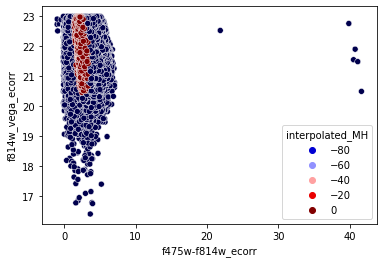

In [56]:
import seaborn as sns
import seaborn as sns

sns.scatterplot(data=phast_df, x='f475w-f814w_ecorr', y='f814w_vega_ecorr', hue='interpolated_MH', palette='seismic')
plt.colorbar(label='MH')
plt.xlabel('F475W-F814W')
plt.ylabel('F814W')
plt.title('Color-Magnitude Diagram')
plt.show()


In [34]:
RGB_metallicity_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr',
       'f475w_crowd', 'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr',
       'f814w_crowd', 'f814w_sharp', 'f814w_flag', 'f814w_vega_ecorr',
       'f475w_vega_ecorr', 'f475w-f814w_ecorr', 'closest_index', 'Zini', 'MH',
       'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label',
       'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X',
       'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'F435Wmag',
       'F475Wmag', 'F555Wmag', 'F606Wmag', 'F625Wmag', 'F775Wmag', 'F814Wmag',
       'F475W_appmag', 'F814W_appmag', 'F475Wmag-F814Wmag',
       'F475W_appmag-F814W_appmag'],
      dtype='object')

In [35]:
phast_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr',
       'f475w_crowd', 'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr',
       'f814w_crowd', 'f814w_sharp', 'f814w_flag', 'f814w_vega_ecorr',
       'f475w_vega_ecorr', 'f475w-f814w_ecorr', 'closest_index'],
      dtype='object')

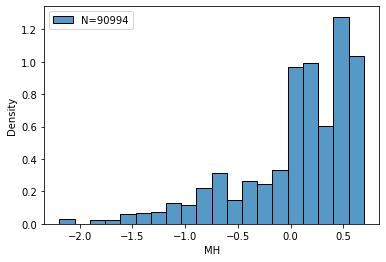

In [39]:
sns.histplot(data=RGB_metallicity_df, x='MH', label=f'N={len(RGB_metallicity_df)}', bins=20, kde=False, stat='density')
plt.legend()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=RGB_metallicity_df['f475w-f814w_ecorr'],
    y=RGB_metallicity_df['f814w_vega_ecorr'],
    mode='markers',
    marker=dict(
        color=RGB_metallicity_df['MH'],
        colorscale='YlOrBr',
        showscale=True
    ),
    hovertemplate=
    '<b>f475w-f814w_ecorr:</b> %{x}<br>' +
    '<b>f814w_vega_ecorr:</b> %{y}<br>' +
    '<b>MH:</b> %{marker.color}<br>' +
    '<b>Zini:</b> %{text}<br>' +
    '<extra></extra>',
    text=RGB_metallicity_df['Zini']
))

fig.update_layout(
    title='Scatter Plot of RGB_metallicity_df',
    xaxis=dict(title='f475w-f814w_ecorr'),
    yaxis=dict(title='f814w_vega_ecorr')
)

fig.update_layout(
    title='Scatter Plot of RGB_metallicity_df',
    xaxis=dict(title='f475w-f814w_ecorr'),
    yaxis=dict(title='f814w_vega_ecorr', autorange='reversed')
)

fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=RGB_metallicity_df['ra'],
    y=RGB_metallicity_df['dec'],
    mode='markers',
    marker=dict(
        color=RGB_metallicity_df['MH'],
        colorscale='YlOrBr',
        showscale=True
    ),
    hovertemplate=
    '<b>f475w-f814w_ecorr:</b> %{x}<br>' +
    '<b>f814w_vega_ecorr:</b> %{y}<br>' +
    '<b>MH:</b> %{marker.color}<br>' +
    '<b>Zini:</b> %{text}<br>' +
    '<extra></extra>',
    text=RGB_metallicity_df['Zini']
))

fig.update_layout(
    title='Scatter Plot of RGB_metallicity_df',
    xaxis=dict(title='ra'),
    yaxis=dict(title='dec', autorange='reversed')
)

fig.show()


In [48]:
# import plotly.graph_objects as go

# # Create the scatter plot
# fig = go.Figure(data=go.Scatter(
#     x=RGB_metallicity_df['f475w-f814w_ecorr'],
#     y=RGB_metallicity_df['f814w_vega_ecorr'],
#     mode='markers',
#     marker=dict(
#         color=RGB_metallicity_df['MH'],
#         colorscale='YlOrBr',
#         showscale=True,
#         colorbar=dict(title='MH')
#     ),
#     hovertemplate=
#     '<b>f475w-f814w_ecorr:</b> %{x}<br>' +
#     '<b>f814w_vega_ecorr:</b> %{y}<br>' +
#     '<b>MH:</b> %{marker.color}<br>' +
#     '<b>Zini:</b> %{text}<br>' +
#     '<extra></extra>',
#     text=RGB_metallicity_df['Zini']
# ))

# # Define the buttons
# buttons = [
#     dict(
#         label='MH',
#         method='update',
#         args=[{'marker.color': RGB_metallicity_df['MH'], 'marker.colorbar.title': 'MH', 'marker.colorscale': 'YlOrBr'}]
#     ),
#     dict(
#         label='LogTe',
#         method='update',
#         args=[{'marker.color': RGB_metallicity_df['logTe'], 'marker.colorbar.title': 'LogTe', 'marker.colorscale': 'magma'}]
#     )
# ]

# # Add the buttons to the layout
# fig.update_layout(
#     title='Scatter Plot of RGB_metallicity_df',
#     xaxis=dict(title='f475w-f814w_ecorr'),
#     yaxis=dict(title='f814w_vega_ecorr', autorange='reversed'),
#     updatemenus=[
#         dict(
#             buttons=buttons,
#             direction='down',
#             showactive=True,
#             x=0.5,
#             y=1.15
#         )
#     ]
# )

# # Update the colorbar scale when switching with the button
# fig.update_traces(marker=dict(colorbar=dict(title='MH')))

# # Show the plot
# fig.show()


In [1]:
# test Plotting for RGB subplots


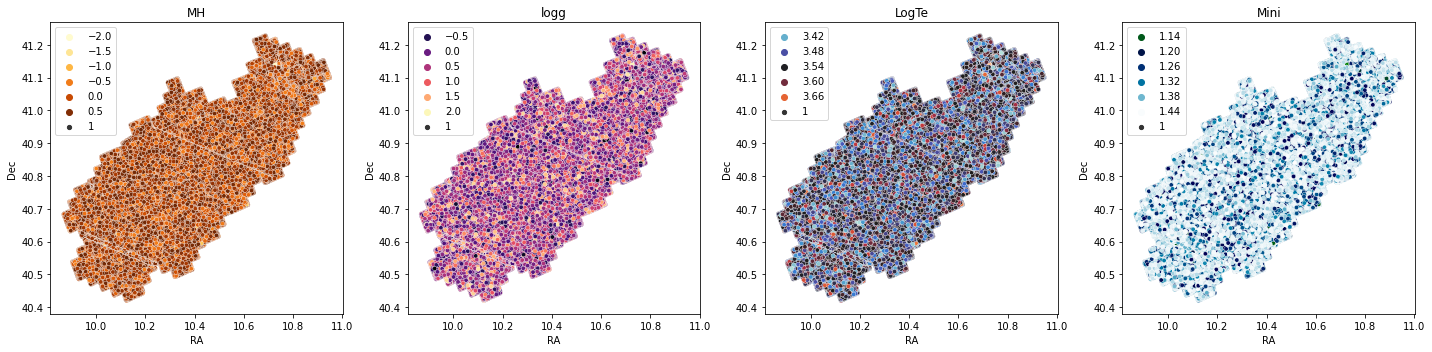

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')
# df = df.sample(300)
# Create a figure with 1 row and 4 columns of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot scatter plot for MH
sns.scatterplot(data=df, x='ra', y='dec', hue='MH', size=1, ax=axs[0], palette='YlOrBr')
axs[0].set_title('MH')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
axs[0].legend().set_visible(True)
# axs[0].figure.colorbar(axs[0].collections[0], ax=axs[0])

# Plot scatter plot for logg
sns.scatterplot(data=df, x='ra', y='dec', hue='logg', size=1, ax=axs[1], palette='magma')
axs[1].set_title('logg')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
axs[1].legend().set_visible(True)
# axs[1].figure.colorbar(axs[1].collections[0], ax=axs[1])

# Plot scatter plot for teff
sns.scatterplot(data=df, x='ra', y='dec', hue='logTe', size=1, ax=axs[2], palette='icefire')
axs[2].set_title('LogTe')
axs[2].set_xlabel('RA')
axs[2].set_ylabel('Dec')
axs[2].legend().set_visible(True)
# axs[2].figure.colorbar(axs[2].collections[0], ax=axs[2])

# Plot scatter plot for Mini
sns.scatterplot(data=df, x='ra', y='dec', hue='Mini', size=0.5, ax=axs[3], palette='ocean')
axs[3].set_title('Mini')
axs[3].set_xlabel('RA')
axs[3].set_ylabel('Dec')
axs[3].legend().set_visible(True)
# axs[3].figure.colorbar(axs[3].collections[0], ax=axs[3])

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_subplots.png')

# Show the plot
plt.show()



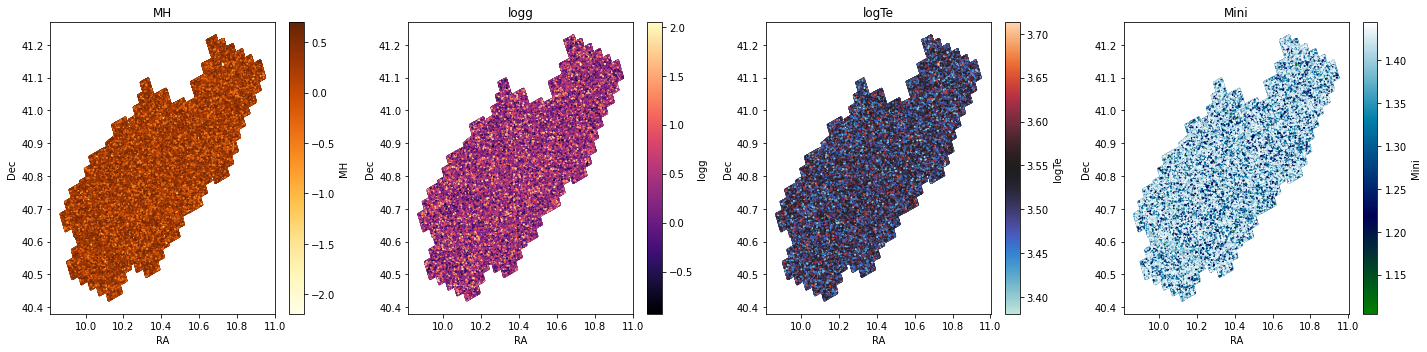

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')
# df = df.sample(300)
# Create a figure with 1 row and 4 columns of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot scatter plot for MH
im1 = axs[0].scatter(df['ra'], df['dec'], c=df['MH'], cmap='YlOrBr', s=1)
axs[0].set_title('MH')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
cbar1 = plt.colorbar(im1, ax=axs[0], label='MH')

# Plot scatter plot for logg
im2 = axs[1].scatter(df['ra'], df['dec'], c=df['logg'], cmap='magma', s=1)
axs[1].set_title('logg')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
cbar2 = plt.colorbar(im2, ax=axs[1], label='logg')

# Plot scatter plot for logTe
im3 = axs[2].scatter(df['ra'], df['dec'], c=df['logTe'], cmap='icefire', s=1)
axs[2].set_title('logTe')
axs[2].set_xlabel('RA')
axs[2].set_ylabel('Dec')
cbar3 = plt.colorbar(im3, ax=axs[2], label='logTe')

# Plot scatter plot for Mini
im4 = axs[3].scatter(df['ra'], df['dec'], c=df['Mini'], cmap='ocean', s=1)
axs[3].set_title('Mini')
axs[3].set_xlabel('RA')
axs[3].set_ylabel('Dec')
cbar4 = plt.colorbar(im4, ax=axs[3], label='Mini')

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_subplots.png')

# Show the plot
plt.show()


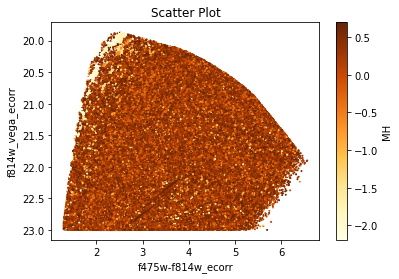

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from the CSV file
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')
# df = df.sample(300)
# Create the scatter plot
scatter = plt.scatter(df['f475w-f814w_ecorr'], df['f814w_vega_ecorr'], c=df['MH'], cmap='YlOrBr', s=1)

# Set the plot title and labels
# plt.title('Scatter Plot')
plt.xlabel('f475w-f814w_ecorr')
plt.ylabel('f814w_vega_ecorr')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('MH')


# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_CMD1.jpeg')

# Show the plot
plt.show()


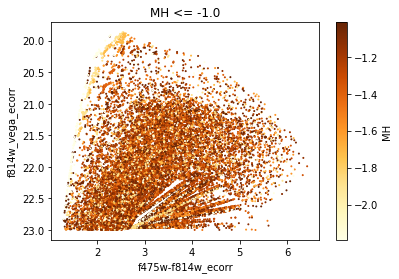

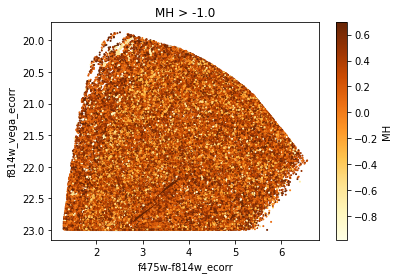

In [26]:
# Split RGB into 2 groups based on low and high metallicity
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')

# Split RGB into 2 groups based on low and high metallicity
low_mh_df = df.loc[(df['MH'] <= -1.0)]
high_mh_df = df.loc[(df['MH'] > -1.0)]

# Create the scatter plot
scatter = plt.scatter(low_mh_df['f475w-f814w_ecorr'], low_mh_df['f814w_vega_ecorr'], c=low_mh_df['MH'], cmap='YlOrBr', s=1)

# Set the plot title and labels
plt.title('MH <= -1.0')
plt.xlabel('f475w-f814w_ecorr')
plt.ylabel('f814w_vega_ecorr')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('MH')


# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_CMD1.jpeg')

# Show the plot
plt.show() 

# Create the scatter plot
scatter = plt.scatter(high_mh_df['f475w-f814w_ecorr'], high_mh_df['f814w_vega_ecorr'], c=high_mh_df['MH'], cmap='YlOrBr', s=1)

# Set the plot title and labels
plt.title('MH > -1.0')
plt.xlabel('f475w-f814w_ecorr')
plt.ylabel('f814w_vega_ecorr')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('MH')


# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_CMD2.jpeg')

# Show the plot
plt.show() 

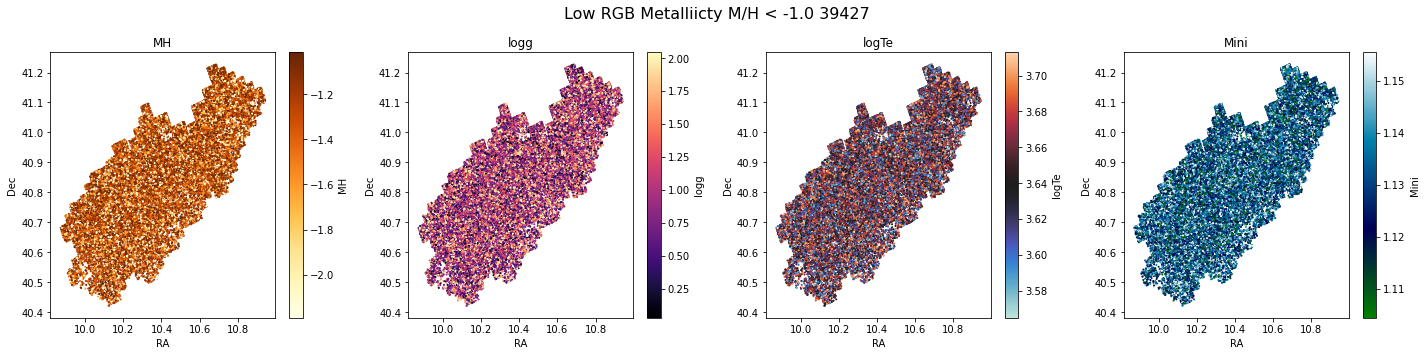

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')
df = df.loc[(df['MH'] <= -1.0)]

# Create a figure with 1 row and 4 columns of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot scatter plot for MH
im1 = axs[0].scatter(df['ra'], df['dec'], c=df['MH'], cmap='YlOrBr', s=1)
axs[0].set_title('MH')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
cbar1 = plt.colorbar(im1, ax=axs[0], label='MH')

# Plot scatter plot for logg
im2 = axs[1].scatter(df['ra'], df['dec'], c=df['logg'], cmap='magma', s=1)
axs[1].set_title('logg')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
cbar2 = plt.colorbar(im2, ax=axs[1], label='logg')

# Plot scatter plot for logTe
im3 = axs[2].scatter(df['ra'], df['dec'], c=df['logTe'], cmap='icefire', s=1)
axs[2].set_title('logTe')
axs[2].set_xlabel('RA')
axs[2].set_ylabel('Dec')
cbar3 = plt.colorbar(im3, ax=axs[2], label='logTe')

# Plot scatter plot for Mini
im4 = axs[3].scatter(df['ra'], df['dec'], c=df['Mini'], cmap='ocean', s=1)
axs[3].set_title('Mini')
axs[3].set_xlabel('RA')
axs[3].set_ylabel('Dec')
cbar4 = plt.colorbar(im4, ax=axs[3], label='Mini')

# Add a suptitle
fig.suptitle(f'Low RGB Metalliicty M/H < -1.0 {len(df)}', fontsize=16)

# Set the background color to white
fig.patch.set_facecolor('white')

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_MH<-1_spatial.jpeg')

# Show the plot
plt.show()


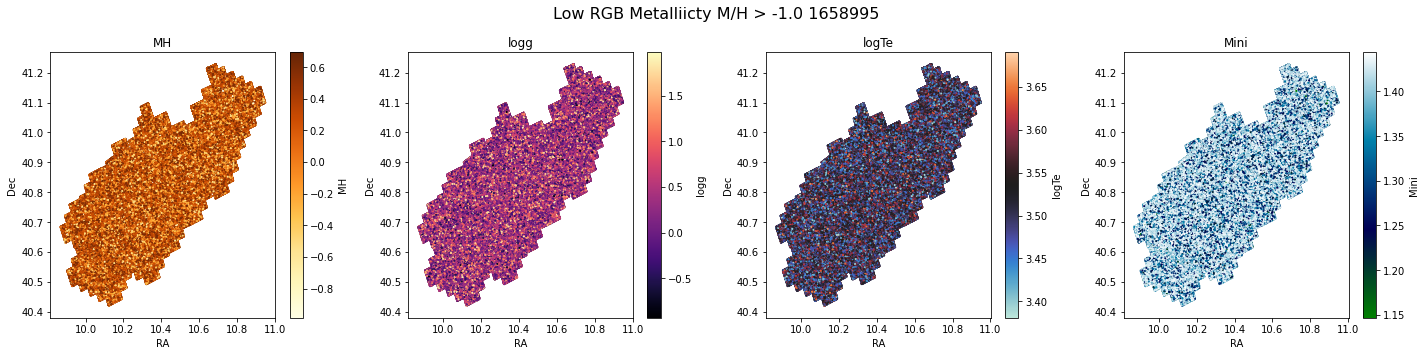

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')
df = df.loc[(df['MH'] > -1.0)]

# Create a figure with 1 row and 4 columns of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot scatter plot for MH
im1 = axs[0].scatter(df['ra'], df['dec'], c=df['MH'], cmap='YlOrBr', s=1)
axs[0].set_title('MH')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
cbar1 = plt.colorbar(im1, ax=axs[0], label='MH')

# Plot scatter plot for logg
im2 = axs[1].scatter(df['ra'], df['dec'], c=df['logg'], cmap='magma', s=1)
axs[1].set_title('logg')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
cbar2 = plt.colorbar(im2, ax=axs[1], label='logg')

# Plot scatter plot for logTe
im3 = axs[2].scatter(df['ra'], df['dec'], c=df['logTe'], cmap='icefire', s=1)
axs[2].set_title('logTe')
axs[2].set_xlabel('RA')
axs[2].set_ylabel('Dec')
cbar3 = plt.colorbar(im3, ax=axs[2], label='logTe')

# Plot scatter plot for Mini
im4 = axs[3].scatter(df['ra'], df['dec'], c=df['Mini'], cmap='ocean', s=1)
axs[3].set_title('Mini')
axs[3].set_xlabel('RA')
axs[3].set_ylabel('Dec')
cbar4 = plt.colorbar(im4, ax=axs[3], label='Mini')

# Add a suptitle
fig.suptitle(f'Low RGB Metalliicty M/H > -1.0 {len(df)}', fontsize=16)

# Set the background color to white
fig.patch.set_facecolor('white')

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/RGB_MH>-1_spatial.jpeg')

# Show the plot
plt.show()


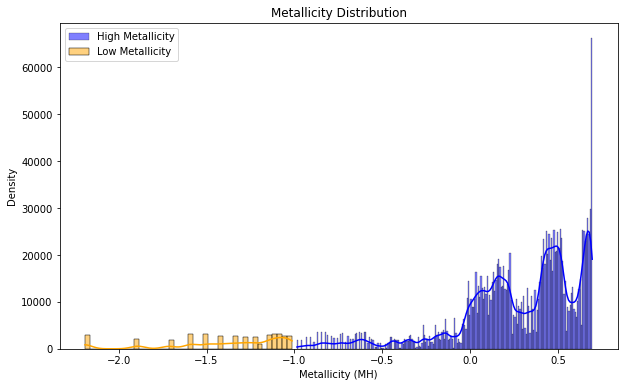

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_RGB_MH_table.csv')

# Split the data into high and low metallicity
high_mh_df = df[df['MH'] > -1.0]
low_mh_df = df[df['MH'] <= -1.0]

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram with KDE for high metallicity
sns.histplot(high_mh_df['MH'], kde=True, color='blue', label='High Metallicity')

# Plot the histogram with KDE for low metallicity
sns.histplot(low_mh_df['MH'], kde=True, color='orange', label='Low Metallicity')

# Set the plot title and labels
plt.title('Metallicity Distribution')
plt.xlabel('Metallicity (MH)')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/split_RGB_MH_distribution.jpeg')
# Show the plot
plt.show()


In [ ]:
# Reduce RGB isochrone to futher rerduce redundant metallicity values


Test interpolation

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_1140/605169063.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z, shading='auto')


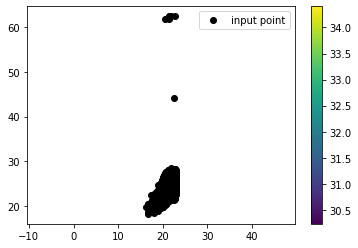

In [17]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/test_reduced_phast_catalog.csv')
x = phast_df['f814w_vega']
y = phast_df['f475w_vega']

rgb_iso_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/RGB_isochrone_table.csv')
X = rgb_iso_df['F814W_appmag']
Y = rgb_iso_df['F475W_appmag']

# rng = np.random.default_rng()
# x = rng.random(10) - 0.5
# y = rng.random(10) - 0.5
z = np.hypot(x, y)
# X = np.linspace(min(x), max(x))
# Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [16]:
phast_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr',
       'f475w_crowd', 'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr',
       'f814w_crowd', 'f814w_sharp', 'f814w_flag', 'f814w_vega_ecorr',
       'f475w_vega_ecorr', 'f475w-f814w_ecorr'],
      dtype='object')